In [31]:
#This is directly from the article  https://aws.amazon.com/pt/blogs/opensource/root-cause-analysis-with-dowhy-an-open-source-python-library-for-causal-machine-learning/

import networkx as nx
import pandas as pd
from dowhy import gcm
from dowhy import CausalModel
import numpy as np
import matplotlib.pyplot as plt

In [23]:
causal_graph = nx.read_adjlist("./CausalDiscovery/pc.adjlist", create_using=nx.DiGraph)

In [19]:
# data = pd.read_csv('../datasets/consolidated.csv',header=0, index_col=0)
data = pd.read_csv('./GenerateDatasets/consolidated.csv',header=0, index_col=0)
consolidated = pd.DataFrame(data)

consolidated = consolidated.drop(columns=['experiment'])#, 'messageDuplicated'])#, 'n_nodes', 'consensus', 'messageDuplicated'])
consolidated = consolidated.rename(columns={'topology':'top'})
consolidated['topology'] = 0
consolidated.loc[consolidated['top'] == 'general', 'topology'] = 1
consolidated = consolidated.drop(columns=['top'])
# consolidated.head(100)

#Rearrange columns according to nodes list
nodes = causal_graph.nodes

consolidated = consolidated[['d', 'messageReceived', 'graft', 'prune', 'iwant', 'dlo', 'dhi', 'dscore', 'dlazy', 'ihave', 'dout', 'gossipFactor', 
                  'interval', 'topology', 'propagationTime', 'messageOverhead', 'messageBandwidth', 'totalBandwidth', 'gossipBandwidth']]#.to_numpy()

# X = consolidated.to_numpy()
# print(X)
consolidated.head(10)

,d,messageReceived,graft,prune,iwant,dlo,dhi,dscore,dlazy,ihave,dout,gossipFactor,interval,topology,propagationTime,messageOverhead,messageBandwidth,totalBandwidth,gossipBandwidth
0,8,8684.0,0.0,0.0,0.0,6,12,4,8,698.0,2,0.25,1.0,0,1773.489130,1193.0,119.3,1134.2,1619.4
1,8,16138.0,0.0,0.0,0.0,6,12,4,8,1032.0,2,0.25,1.0,0,2037.555657,2188.0,218.8,2090.7,1722.7
2,8,13689.0,0.0,0.0,0.0,6,12,4,8,1339.0,2,0.25,1.0,0,1770.802686,1874.0,187.4,1798.3,1559.2
3,8,13750.0,0.0,0.0,0.0,6,12,4,8,963.0,2,0.25,1.0,0,1765.751992,1898.0,189.8,1788.7,1585.7
4,8,13993.0,0.0,0.0,2.0,6,12,4,8,968.0,2,0.25,1.0,0,1960.033882,1930.0,193.0,1822.5,1834.3
5,8,16160.0,0.0,0.0,0.0,6,12,4,8,1283.0,2,0.25,1.0,0,1962.132923,2210.0,221.0,2107.2,1811.6
6,8,13942.0,0.0,0.0,0.0,6,12,4,8,970.0,2,0.25,1.0,0,1982.278101,1926.0,192.6,1814.3,1485.3
7,8,14533.0,0.0,0.0,0.0,6,12,4,8,961.0,2,0.25,1.0,0,1808.053122,2002.0,200.2,1888.9,1315.4
8,8,15959.0,0.0,0.0,0.0,6,12,4,8,1292.0,2,0.25,1.0,0,1996.014559,2179.0,217.9,2082.9,1499.2
9,8,14792.0,0.0,0.0,0.0,6,12,4,8,957.0,2,0.25,1.0,0,1823.973827,2039.0,203.9,1921.0,1346.3


In [24]:
# Create the structural causal model object
scm = gcm.StructuralCausalModel(causal_graph)

# Automatically assign generative models to each node based on the given data
gcm.auto.assign_causal_mechanisms(scm, consolidated)

In [25]:
#Fit model to data
gcm.fit(scm, consolidated)

Fitting causal mechanism of node topology: 100%|██████████| 19/19 [00:16<00:00,  1.15it/s]       


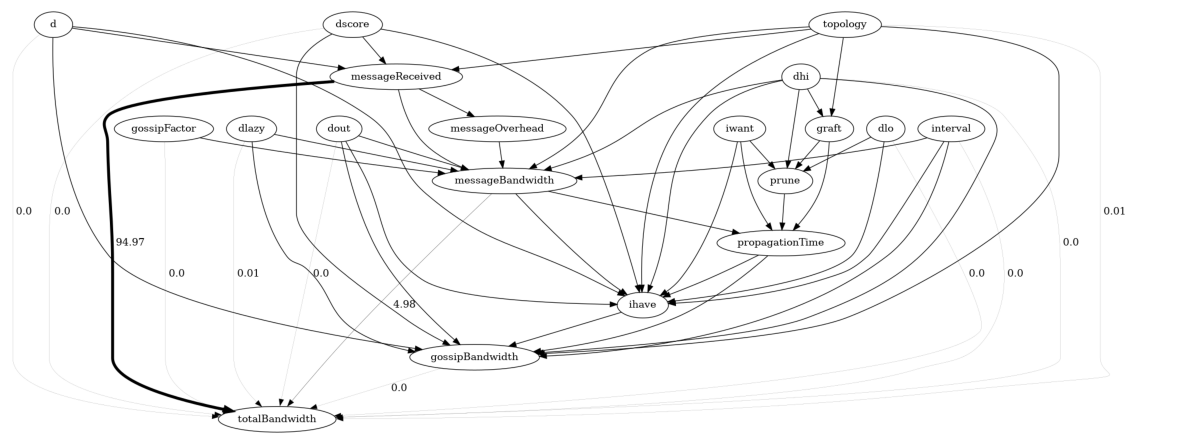

In [26]:
#Key factors influencing Bandwidth?

def convert_to_percentage(value_dictionary):
    total_absolute_sum = np.sum([abs(v) for v in value_dictionary.values()])
    return {k: abs(v) / total_absolute_sum * 100 for k, v in value_dictionary.items()}


arrow_strengths = gcm.arrow_strength(scm, target_node='totalBandwidth')


fig, ax = plt.subplots(figsize=(15,20)) 
gcm.util.plot(causal_graph, causal_strengths=convert_to_percentage(arrow_strengths))#, figure_size=[15, 10])

Estimating Shapley Values. Average change of Shapley values in run 3 (15 evaluated permutations): -2.491458139726459%: 100%|██████████| 1/1 [04:40<00:00, 280.72s/it]


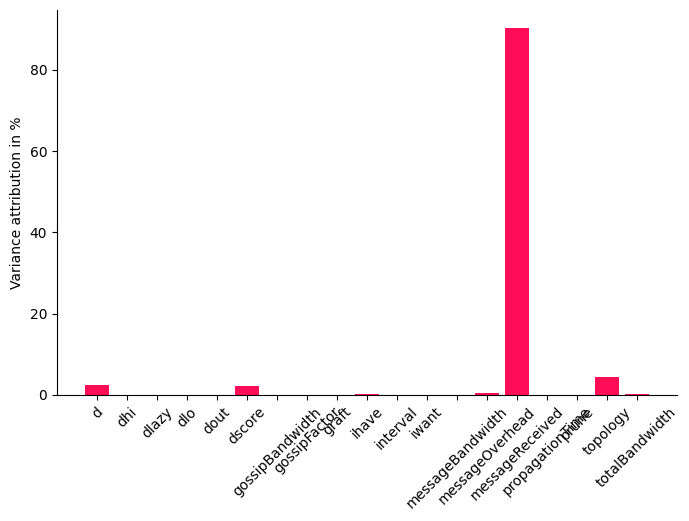

In [28]:
def bar_plot(value_dictionary, ylabel, uncertainty_attribs=None, figsize=(8, 5)):
    value_dictionary = {k: value_dictionary[k] for k in sorted(value_dictionary)}
    if uncertainty_attribs is None:
        uncertainty_attribs = {node: [value_dictionary[node], value_dictionary[node]] for node in value_dictionary}

    _, ax = plt.subplots(figsize=figsize)
    ci_plus = [uncertainty_attribs[node][1] - value_dictionary[node] for node in value_dictionary.keys()]
    ci_minus = [value_dictionary[node] - uncertainty_attribs[node][0] for node in value_dictionary.keys()]
    yerr = np.array([ci_minus, ci_plus])
    yerr[abs(yerr) < 10**-7] = 0
    plt.bar(value_dictionary.keys(), value_dictionary.values(), yerr=yerr, ecolor='#1E88E5', color='#ff0d57', width=0.8)
    plt.ylabel(ylabel)
    plt.xticks(rotation=45)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    plt.show()


iccs = gcm.intrinsic_causal_influence(scm, target_node='totalBandwidth', num_samples_randomization=500)

bar_plot(convert_to_percentage(iccs), ylabel='Variance attribution in %')

In [35]:
gml_graph = "\n".join(nx.generate_gml(causal_graph))

# With graph
# model = CausalModel(
#     data=consolidated,
#     treatment='messageOverhead',
#     outcome='totalBandwidth',
#     graph=gml_graph
# )
# model.view_model()

# estimand = model.identify_effect()
# print(estimand)

NetworkXError: <dowhy.gcm.stochastic_models.EmpiricalDistribution object at 0x7fa17bdd8c10> is not a string